In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import central_crop, pad_to_bounding_box, resize

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4 
session = tf.compat.v1.Session(config=config)

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3799780236880887250
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14636806062672162237
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [7]:
x = []
y = []
size = (360, 360) 
search_names = ['grand+canyon', 'Eiffel+Tower', 'Great+Wall', 'Maldives', 'Venice', 'abu+simbel', 'Colosseum', 'Hawaii', 'alps', 'Himalaya']
for name in search_names:
    for i in range(1, 50):
        path = f"img/{name}/{i}.jpg"
        img = load_img(path)
        img_array = img_to_array(img) / 255
        img_resize = resize(img_array, size)
        x.append(np.array(img_resize))
        y.append(name)
x = np.array(x)

FileNotFoundError: [Errno 2] No such file or directory: 'img/grand+canyon/1.jpg'

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=111)

In [9]:
en = LabelEncoder()
y_train_en = en.fit_transform(y_train)
y_test_en = en.fit_transform(y_test)

In [10]:
y_train_oh = to_categorical(y_train_en)
y_test_oh = to_categorical(y_test_en)

In [11]:
y_test_en

array([7, 6, 5, 7, 7, 3, 2, 9, 4, 6, 0, 1, 2, 6, 2, 8, 1, 0, 9, 5, 6, 0,
       3, 9, 0, 7, 7, 5, 8, 3, 1, 9, 8, 3, 7, 9, 4, 7, 0, 0, 6, 9, 1, 4,
       0, 9, 8, 5, 2, 5, 5, 6, 1, 9, 4, 7, 9, 4, 5, 4, 9, 5, 5, 3, 6, 0,
       8, 6, 0, 0, 0, 7, 5, 4, 7, 2, 6, 2, 5, 7, 1, 5, 3, 3, 1, 0, 9, 0,
       6, 8, 5, 5, 7, 9, 0, 0, 2, 0], dtype=int64)

In [12]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Conv2D(8, (3,3), strides=1, activation='relu', padding='same', input_shape=(360, 360, 3)))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))

    model.add(Conv2D(16, (3,3), strides=1, activation='relu', padding='same'))
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 360, 360, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 180, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 180, 180, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0

In [13]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [14]:
with tf.device('/GPU:0'):
    hist = model.fit(x_train, y_train_oh, batch_size=1, epochs=50, validation_data=(x_test, y_test_oh))

Epoch 1/50
392/392 [==============================] - 13s 4ms/step - loss: 2.2510 - accuracy: 0.2883 - val_loss: 1.3372 - val_accuracy: 0.5816
Epoch 2/50
392/392 [==============================] - 2s 4ms/step - loss: 1.0915 - accuracy: 0.6403 - val_loss: 0.6136 - val_accuracy: 0.8469
Epoch 3/50
392/392 [==============================] - 2s 4ms/step - loss: 0.3615 - accuracy: 0.9082 - val_loss: 0.5121 - val_accuracy: 0.8367
Epoch 4/50
392/392 [==============================] - 2s 4ms/step - loss: 0.1307 - accuracy: 0.9643 - val_loss: 0.5684 - val_accuracy: 0.8367
Epoch 5/50
392/392 [==============================] - 2s 4ms/step - loss: 0.1274 - accuracy: 0.9617 - val_loss: 0.4244 - val_accuracy: 0.9082
Epoch 6/50
392/392 [==============================] - 2s 4ms/step - loss: 0.0680 - accuracy: 0.9872 - val_loss: 0.1078 - val_accuracy: 0.9796
Epoch 7/50
392/392 [==============================] - 2s 4ms/step - loss: 0.2196 - accuracy: 0.9668 - val_loss: 0.3788 - val_accuracy: 0.9184
Epoch

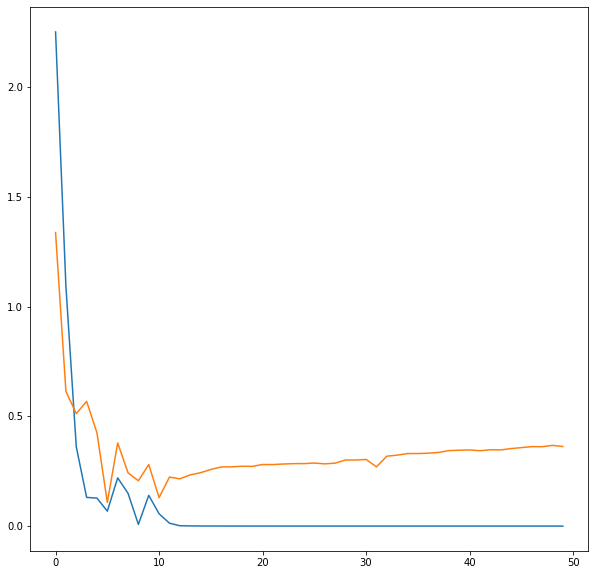

In [15]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

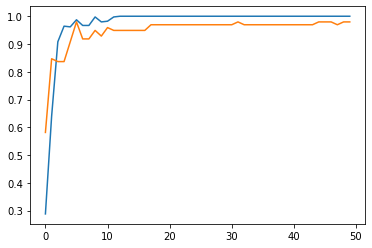

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [18]:
model.evaluate(x_test, y_test_oh)

4/4 [==============================] - 1s 26ms/step - loss: 0.3624 - accuracy: 0.9796


[0.3624327480792999, 0.9795918464660645]

In [36]:
pred = model.predict(x_test)

In [37]:
for i in range(len(pred)):
    print(np.argmax(pred[i]) == y_test_en[i])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
